In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import pandas as pd
import joblib
import torch
from sklearn.model_selection import train_test_split
from src.data.preprocess import data_preprocessing
from src.data.resample import data_resampling
from src.visualization.plot_curves import plot_precision_recall, plot_roc_curve
from src.inference.model_loading import mlp_model_loading
from src.inference.predict import predict_proba_torch
from src.training.evaluate import evaluate_model
from src.training.evaluate import evaluate_torch_model

In [3]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
labeled_path = os.path.join(parent_dir, "data", "data_final","labeled_data.csv")
labeled_data = pd.read_csv(labeled_path)

In [4]:
X_labled, y, scaler, fitted_label_encoders = data_preprocessing(labeled_data, is_train=True, scaler=None, label_encoders=None)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_labled, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
X_train_resampled, y_train_resampled =data_resampling(X_train, y_train)

d:\24fall\lent term\Project2\MusicStreamingSubscriptionsChurnPredictor\churn_env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [7]:
X_test_numpy = X_test.astype('float32') 
X_test_tensor = torch.tensor(X_test_numpy)
y_test_tensor = torch.tensor(y_test.astype(int).values, dtype=torch.float32)

In [11]:
glm_model_path = os.path.join(parent_dir, "models","glm_model.pkl")
lgbm_model_path = os.path.join(parent_dir, "models","lgbm_model.pkl")
glm_model = joblib.load(glm_model_path)
lgbm_model = joblib.load(lgbm_model_path)

d:\24fall\lent term\Project2\MusicStreamingSubscriptionsChurnPredictor\churn_env\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [8]:
hidden_sizes = [512, 256]
dropout_rate=0.1
input_size = len(X_test_tensor[0,:])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_model_path = os.path.join(parent_dir, "models","mlp_model.pt")   
mlp_model = mlp_model_loading(mlp_model_path, input_size, hidden_sizes, dropout_rate)
mlp_ssl_model_path = os.path.join(parent_dir, "models","mlp_model.pt")
mlp_ssl_model = mlp_model_loading(mlp_ssl_model_path, input_size, hidden_sizes, dropout_rate)

In [15]:
mlp_probs = predict_proba_torch(mlp_model, X_test_tensor)
ssl_probs = predict_proba_torch(mlp_ssl_model, X_test_tensor)

glm_probs = glm_model.predict_proba(X_test_numpy)[:, 1]
lgbm_probs = lgbm_model.predict_proba(X_test_numpy)[:, 1]


d:\24fall\lent term\Project2\MusicStreamingSubscriptionsChurnPredictor\churn_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [21]:
y_pred_glm, y_prob_glm = evaluate_model(glm_model, X_test, y_test, model_name="GLM")

y_pred_lgbm, y_prob_lgbm = evaluate_model(lgbm_model, X_test, y_test, model_name="GLM")


GLM Evaluation Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89    176726
           1       0.31      0.86      0.46     17466

    accuracy                           0.82    194192
   macro avg       0.65      0.83      0.67    194192
weighted avg       0.92      0.82      0.85    194192

GLM AUC: 0.9101


d:\24fall\lent term\Project2\MusicStreamingSubscriptionsChurnPredictor\churn_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\24fall\lent term\Project2\MusicStreamingSubscriptionsChurnPredictor\churn_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



GLM Evaluation Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    176726
           1       0.71      0.63      0.67     17466

    accuracy                           0.94    194192
   macro avg       0.84      0.80      0.82    194192
weighted avg       0.94      0.94      0.94    194192

GLM AUC: 0.9530


In [ ]:
y_pred_mlp, y_prob_mlp = evaluate_torch_model(mlp_model, X_test_tensor, y_test_tensor, threshold=0.78, model_name="MLP Model")

y_pred_ssl, y_prob_ssl = evaluate_torch_model(mlp_ssl_model, X_test_tensor, y_test_tensor, threshold=0.78, model_name="MLP SSL Model")


MLP Model Evaluation Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    176726
         1.0       0.66      0.67      0.66     17466

    accuracy                           0.94    194192
   macro avg       0.82      0.82      0.82    194192
weighted avg       0.94      0.94      0.94    194192

MLP Model AUC: 0.9479

MLP SSL Model Evaluation Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    176726
         1.0       0.66      0.67      0.66     17466

    accuracy                           0.94    194192
   macro avg       0.82      0.82      0.82    194192
weighted avg       0.94      0.94      0.94    194192

MLP SSL Model AUC: 0.9479


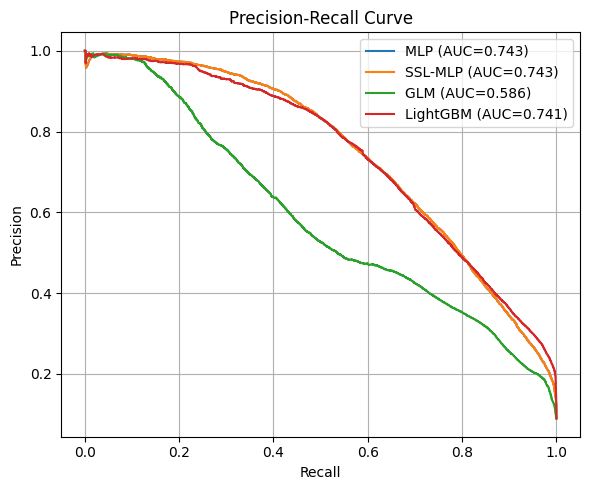

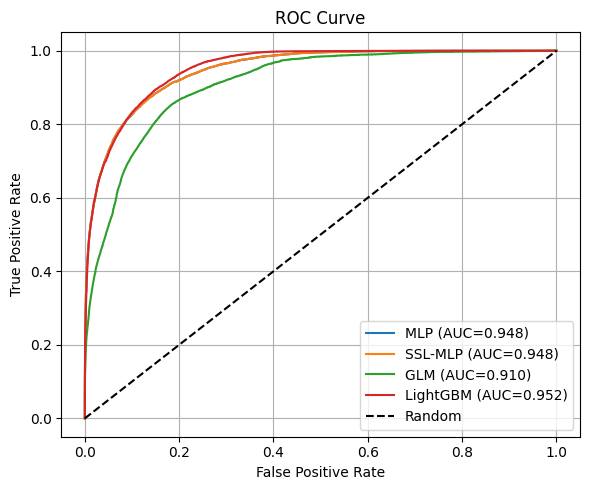

In [16]:
y_test_array = y_test.numpy() if torch.is_tensor(y_test) else y_test

model_probs = {
    "MLP": mlp_probs,
    "SSL-MLP": ssl_probs,
    "GLM": glm_probs,
    "LightGBM": lgbm_probs
}

plot_precision_recall(y_test, model_probs)
plot_roc_curve(y_test, model_probs)